In [2]:
import pandas as pd
import numpy as np

### Read the data

In [39]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [40]:
print train.shape
print test.shape

(114321, 133)
(114393, 132)


In [41]:
train[:3]

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472


### Prepare the data

In [42]:
def prepare_features(data):
    data['NaNCount'] = data.isnull().sum(axis=1)
    data.fillna(-1, inplace=True)

In [43]:
prepare_features(train)
prepare_features(test)

In [44]:
# Replace labels with floats
from sklearn.preprocessing import LabelEncoder
lbl_enc = LabelEncoder()

for f in test.columns:
    if train[f].dtype=='object':
        lbl_enc.fit(list(train[f])+list(test[f]))
        train[f] = lbl_enc.transform(list(train[f].values))
        test[f] = lbl_enc.transform(list(test[f].values))

### Try Random Forest 

In [34]:
train.target = train.target.apply(lambda x: 0.999 if x == 1 else 0.001)

In [45]:
from sklearn.cross_validation import train_test_split
x_tr, x_cv, y_tr, y_cv = train_test_split(train[test.columns], train.target, test_size = 0.05,  random_state = 42)

In [46]:
%%time
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=25,
    max_depth=10,
    n_jobs=3,
    random_state=42,
    oob_score=True
)
rf.fit(x_tr, y_tr)

Wall time: 1min 9s


In [48]:
from sklearn.metrics import log_loss
pred_RF = rf.predict(x_cv)
log_loss(y_cv, pred_RF)

0.46744541977734927

In [49]:
pred_RF[:10]

array([ 0.98407463,  0.85708072,  0.28018602,  0.92764624,  0.91947151,
        0.69316745,  0.76303922,  0.97515948,  0.85550994,  0.88023081])

The best: 0.46744541977734927

In [50]:
%matplotlib inline
import matplotlib as mpl
import pylab as plt
import scipy

Feature ranking:


C:\Program Files\Anaconda\lib\site-packages\matplotlib\figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


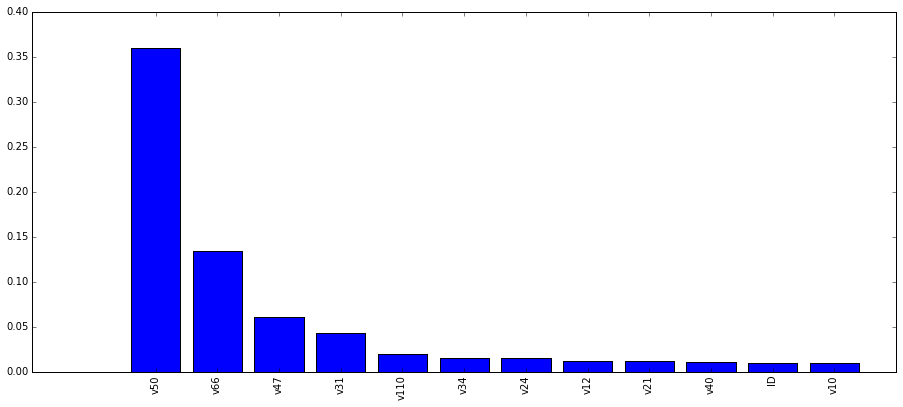

In [51]:
# Show feature importances
importances = rf.feature_importances_
low_value = 0.010
# std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
inds = [i for i in indices if importances[i] > low_value]

print("Feature ranking:")

labels = [list(test.columns)[i] for i in indices.tolist() if importances[i] > low_value]
x = scipy.array(xrange(len(inds)))
y = scipy.array(importances[inds])
f = plt.figure(figsize=(12,5))
ax = f.add_axes([1, 1, 1, 1])
ax.bar(x, y, align='center')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
f.show()

### Submit RF 

In [52]:
RF = rf.predict(test)

In [54]:
submit = pd.read_csv('data/sample_submission.csv')
submit.PredictedProb = RF
submit.to_csv('submit.csv', index=False)

### Try XGB 

In [58]:
# Set params

params = {"objective": "binary:logistic",
          "booster": "gbtree",
          "eval_metric": "logloss",
          "eta": 0.01,
          "max_depth": 7,
          "subsample": 0.75,
          "colsample_bytree": 0.68,
          "silent": 1
          }
num_trees = 1800
stop = 30
boost_round = 1800

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(x_tr.values, y_tr)
dvalid = xgb.DMatrix(x_cv.values, y_cv)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_boost_round=boost_round, evals=watchlist, early_stopping_rounds=stop, verbose_eval=True)

Will train until train error hasn't decreased in 30 rounds.
[0]	eval-logloss:0.689351	train-logloss:0.689323
[1]	eval-logloss:0.685639	train-logloss:0.685567
[2]	eval-logloss:0.682160	train-logloss:0.682053
[3]	eval-logloss:0.678603	train-logloss:0.678458
[4]	eval-logloss:0.675530	train-logloss:0.675310
[5]	eval-logloss:0.672549	train-logloss:0.672245
[6]	eval-logloss:0.669340	train-logloss:0.668984
[7]	eval-logloss:0.666042	train-logloss:0.665636
[8]	eval-logloss:0.662766	train-logloss:0.662324
[9]	eval-logloss:0.659986	train-logloss:0.659472
[10]	eval-logloss:0.657294	train-logloss:0.656721
[11]	eval-logloss:0.654358	train-logloss:0.653729
[12]	eval-logloss:0.651591	train-logloss:0.650935
[13]	eval-logloss:0.648925	train-logloss:0.648227
[14]	eval-logloss:0.646220	train-logloss:0.645474
[15]	eval-logloss:0.643351	train-logloss:0.642566
[16]	eval-logloss:0.640627	train-logloss:0.639819
[17]	eval-logloss:0.638249	train-logloss:0.637418
[18]	eval-logloss:0.635496	train-logloss:0.634616


The best score: 

In [15]:
dtest = xgb.DMatrix(test.as_matrix())
XGB = gbm.predict(dtest)
indices = XGB < 0
XGB[indices] = 0

In [17]:
submit = pd.read_csv('data/sample_submission.csv')
submit.PredictedProb = XGB
submit.to_csv('submit.csv', index=False)